# Ejercicio 2

Extender el autoencoder para que opere como un Autoencoder Variacional.

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits

import os
import sys; sys.path.append("..")

from src.utils import read_data
from src.optimizer import Adam
from src.autoencoder import Autoencoder
from src.perceptron_multicapa import StochasticLayer, Layer

## Digitos

In [ ]:
digits = load_digits()

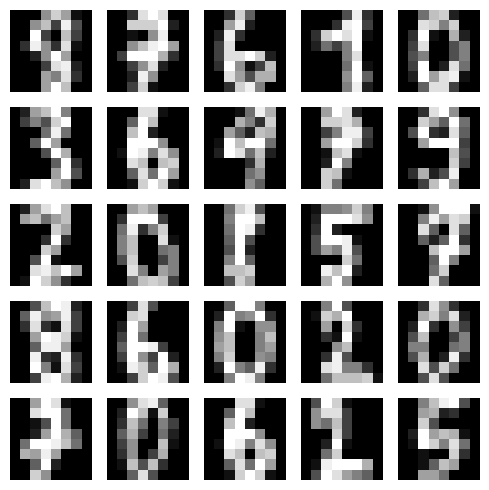

In [ ]:
indices = [i for i, y in enumerate(digits.target) if y in [1,2,3,4,5,6,7,8,9,0]] # TODO probar diferentes combinaciones
fig, ax = plt.subplots(5, 5, figsize=(5, 5))
for i in range(5):
    for j in range(5):
        ind = np.random.choice(indices)
        ax[i, j].imshow(digits.data[ind].reshape(8, 8), cmap="gray")
        #ax[i, j].set_title(digits.target[ind])
        ax[i, j].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
vae = Autoencoder([
    Layer(64, 32, "sigmoid"),
    Layer(32, 16, "sigmoid"),
    StochasticLayer(16, 2),
    Layer( 2, 16, "sigmoid"),
    Layer(16, 32, "sigmoid"),
    Layer(32, 64, "sigmoid"),
], bottleneck_index=2, loss_fun="mse")

vae.optimizer.learning_rate = 0.01
history = vae.train_autoencoder(digits.data / 16, epochs=10, batch_size=10)

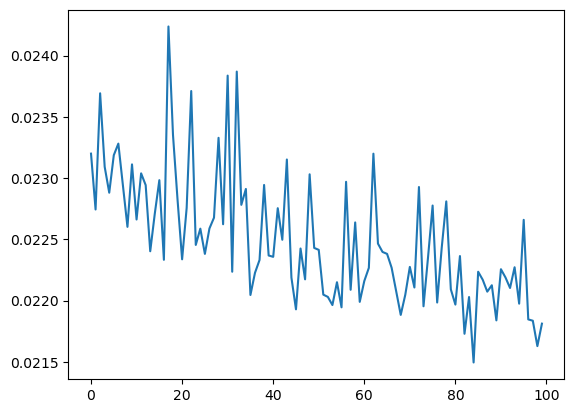

In [94]:
e = [h["epoch"] for h in history]
l = [h["train_loss"] for h in history]
plt.plot(e, l)
plt.show()

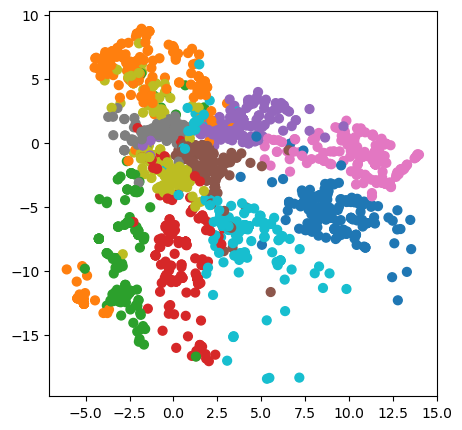

In [194]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
Z = np.array([vae.encode(x) for x in digits.data])
scatter = plt.scatter(Z[:, 0], Z[:, 1], c=digits.target, cmap='tab10', s=40)
plt.show()

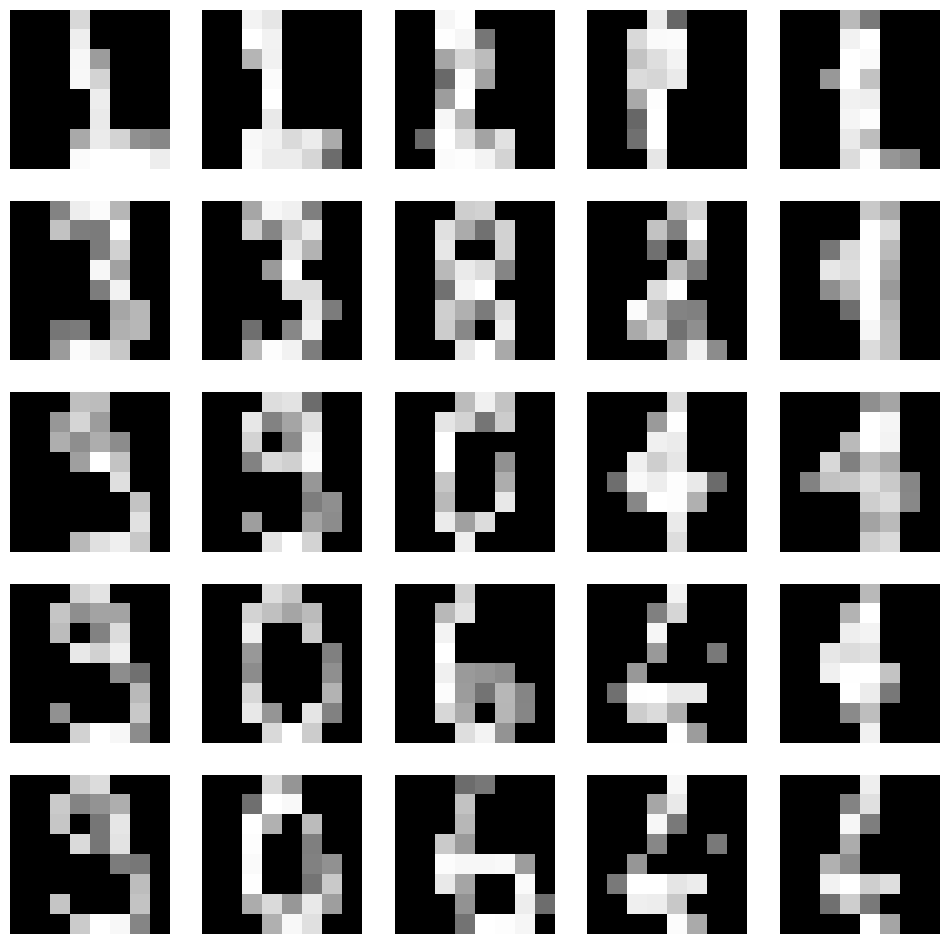

In [ ]:
cantidad = 5
x = np.linspace(-5, 15, cantidad)
y = np.linspace(-15, 10, cantidad)
threshold = 0.4
fig, ax = plt.subplots(len(x), len(y), figsize=(12,12))
for i, xi in enumerate(x):
	for j, yj in enumerate(y):	
		numero = vae.decode([xi, yj])
		numero = np.where(numero > threshold, numero, 0)
		ax[i, j].imshow(numero.reshape(8, 8), cmap='gray', interpolation='nearest')
		ax[i, j].set_axis_off()
plt.show()

## Flores

In [118]:
folder = "../data/banderas"
imagenes = []
for file in os.listdir(folder):
	imagen_original = Image.open(os.path.join(folder, file)).convert("RGB")
	imagen_reescalada = imagen_original.resize((14, 7), Image.NEAREST)
	imagenes.append(np.array(imagen_reescalada) / 255)
imagenes = np.array(imagenes)

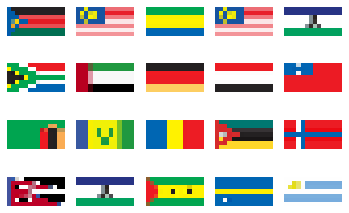

In [129]:
n_row = 4
n_col = 5
fig, ax = plt.subplots(n_row, n_col)
for r in range(n_row):
	for c in range(n_col):
		idx = np.random.randint(len(imagenes))
		ax[r,c].imshow(imagenes[idx])
		ax[r,c].set_axis_off()
plt.show()

In [172]:
n, h, w, c = imagenes.shape
dim_flatten = h * w * c

vae = Autoencoder(
    layers=[
        Layer(dim_flatten, 126, "sigmoid"),
        Layer(126, 32, "sigmoid"),
        StochasticLayer(32, 2),
        Layer(2, 32, "sigmoid"),
        Layer(32, 126, "sigmoid"),
        Layer(126, dim_flatten, "sigmoid")
    ],
    bottleneck_index=2,
    loss_fun="bce"
)
X = imagenes.reshape((n, -1))[0:30]
#vae.optimizer.learning_rate = 0.05
history = vae.train_autoencoder(X, epochs=5000, batch_size=1)

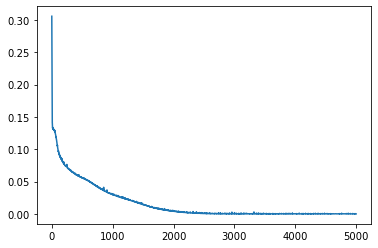

In [173]:
e = [h["epoch"] for h in history]
l = [h["train_loss"] for h in history]
plt.plot(e, l)
plt.show()

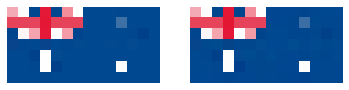

In [211]:
in_arr = X[8]
Y = vae.forward(in_arr)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(in_arr.reshape(h, w, c))
ax[0].set_axis_off()
ax[1].imshow(Y.reshape(h, w, c))
ax[1].set_axis_off()

plt.show()

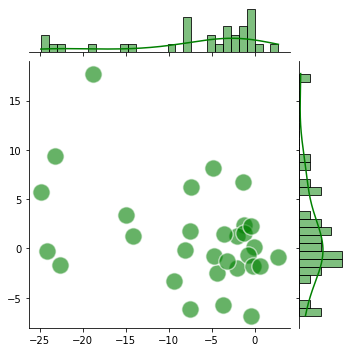

In [ ]:
import seaborn as sns
xs, ys = [], []
for col, bandera in enumerate(X):
    x, y = vae.encode(bandera)
    xs.append(x)
    ys.append(y)
    
sns.jointplot(x=xs, y=ys, kind="scatter", color="green", s=300, alpha=0.6, palette="tab10", 
              height=5, marginal_kws={"kde": True, "bins":30})
plt.show()

[ 0.65976554 -1.79255722] [-22.84205693 -21.70138298]


C:\Users\User\AppData\Local\Temp\ipykernel_30664\2194385797.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


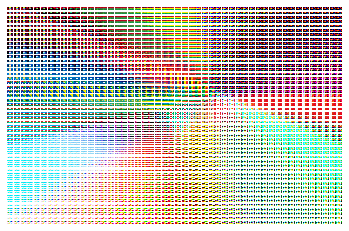

In [257]:
stochastic_layer = vae.layers[vae.bottleneck_index]
mu  = stochastic_layer.mu
log_var = stochastic_layer.log_var
std = np.exp(0.5 * stochastic_layer.log_var)

print(mu, log_var)

cantidad = 50
x = np.linspace(-12, 8, cantidad)
y = np.linspace(-15, 10, cantidad)

fig, ax = plt.subplots(len(x), len(y))
for col, xi in enumerate(x):
	for row, yj in enumerate(reversed(y)):	
		arr = vae.decode([xi, yj])
		
		ax[row, col].imshow(arr.reshape(h, w, c), interpolation='nearest')
		ax[row, col].set_axis_off()

plt.tight_layout()
plt.show()

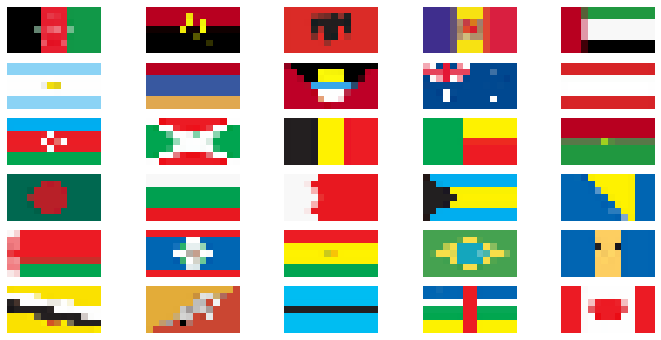

In [185]:
fig, ax = plt.subplots(len(X) // 5, 5, figsize=(12, 6))
for i, bandera in enumerate(X):
	ax[i//5,i%5].imshow(bandera.reshape(h, w, c))
	ax[i//5,i%5].set_axis_off()
plt.show()

(-0.5, 13.5, 6.5, -0.5)

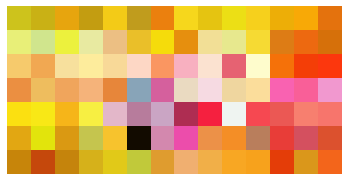

In [236]:
arr = vae.decode([-0.2, -2.7])
plt.imshow(arr.reshape(h, w, c))
plt.axis("off")